In [3]:
import pandas as pd
import numpy as np
from loaders import *
import math
import random
from attn_masked import parse_timeloop_stats, aggregate_timeloop_runs

In [4]:
matrix_size = 2048 # CHANGE

dataflow_permuations = [['M', 'N', 'K'], ['M', 'K', 'N'], ['N', 'K', 'M'], ['N', 'M', 'K'], ['K', 'N', 'M'], ['K', 'M', 'N']]
'''
6 different dataflow permutations
9 components for dataflow
= 6^9 = 10077696 possible combinations
'''
# generate all the data flow permuations
def get_dataflow_permutations():
    dataflow_perumations = []
    
    for DRAM in dataflow_permuations:
        for ClusterArray in dataflow_permuations:
            for GLB_Cluster in dataflow_permuations:
                for glb in dataflow_permuations:
                    for PE_Cluster in dataflow_permuations:
                        for iact_spad in dataflow_permuations:
                            for weight_spad in dataflow_permuations:
                                for psum in dataflow_permuations:
                                    for reg in dataflow_permuations:
                                        permutation = {
                                            "DRAM": DRAM,
                                            "ClusterArray": ClusterArray,
                                            # "GLB_Cluster": GLB_Cluster,
                                            # "glb": glb,
                                            "PE_Cluster": PE_Cluster,
                                            "iact_spad": iact_spad,
                                            "weight_spad": weight_spad,
                                            "psum": psum,
                                            "reg": reg,
                                        }
                                        dataflow_perumations.append(permutation)
    return dataflow_perumations

# generate all the possible factor permutations for a specific rank (ie, M, N, or K)
def get_factor_permutations():
    factor_permutations = []
    iact_spad_depth = 16 # M, K
    weight_spad_depth = 192 # K, N
    psum_spad_depth = 32 # M, N

    max_K = int(max(math.log2(weight_spad_depth), math.log2(iact_spad_depth)))
    max_M = int(max(math.log2(psum_spad_depth), math.log2(iact_spad_depth)))
    max_N = int(max(math.log2(weight_spad_depth), math.log2(psum_spad_depth)))     
    
    for DRAM_M in [2**i for i in range(int(math.log2(matrix_size)) + 1)]:
        for DRAM_N in [2**i for i in range(int(math.log2(matrix_size)) + 1)]:
                for DRAM_K in [2**i for i in range(int(math.log2(matrix_size)) + 1)]:

                    for iact_spad_M in [2**i for i in range(max_M + 1)]:
                        for iact_spad_K in [2**j for j in range(max_K + 1)]:
                            iact_spad_N = 1  # Inputs → M & K only
                    
                            for weight_spad_K in [2**i for i in range(max_K + 1)]:
                                for weight_spad_N in [2**j for j in range(max_N + 1)]:
                                    weight_spad_M = 1  # Weights → K & N only
                    
                                    for psum_M in [2**i for i in range(max_M + 1)]:
                                        for psum_N in [2**j for j in range(max_N + 1)]:
                                            psum_K = 1  # Outputs → M & N only
                                            # tile size must fit into the iact_spad, weight_spad, and psum_spad
                                            if not (
                                                ((iact_spad_M * weight_spad_M * psum_M) * (iact_spad_K * weight_spad_K * psum_K) <=  iact_spad_depth) and
                                                ((iact_spad_K * weight_spad_K * psum_K) * (iact_spad_N * weight_spad_N * psum_N) <=  weight_spad_depth) and
                                                ((iact_spad_M * weight_spad_M * psum_M) * (iact_spad_N * weight_spad_N * psum_N) <=  psum_spad_depth)
                                            ):
                                                break

                                            if ((DRAM_M * iact_spad_M * weight_spad_M * psum_M == matrix_size) and
                                                (DRAM_N * iact_spad_N * weight_spad_N * psum_N == matrix_size) and
                                                (DRAM_K * iact_spad_K * weight_spad_K * psum_K == matrix_size)):
                                                permuation = {
                                                    "DRAM_M": DRAM_M,
                                                    "DRAM_N": DRAM_N,
                                                    "DRAM_K": DRAM_K,

                                                    "ClusterArray_M": 1,
                                                    "ClusterArray_N": 1,
                                                    "ClusterArray_K": 1,

                                                    # "GLB_Cluster_M": 1,
                                                    # "GLB_Cluster_N": 1,
                                                    # "GLB_Cluster_K": 1,

                                                    # "glb_M": 4,
                                                    # "glb_N": 4,
                                                    # "glb_K": 4,

                                                    "PE_Cluster_M": 1,
                                                    "PE_Cluster_N": 1,
                                                    "PE_Cluster_K": 1,

                                                    "iact_spad_M": iact_spad_M,
                                                    "iact_spad_N": iact_spad_N,
                                                    "iact_spad_K": iact_spad_K,

                                                    "weight_spad_M": weight_spad_M,
                                                    "weight_spad_N": weight_spad_N,
                                                    "weight_spad_K": weight_spad_K,

                                                    "psum_M": psum_M,
                                                    "psum_N": psum_N,
                                                    "psum_K": psum_K,

                                                    "reg_M": 1,
                                                    "reg_N": 1,
                                                    "reg_K": 1,
                                                }
                                                factor_permutations.append(permuation)                            
    return factor_permutations

In [5]:
dataflow_permutations = get_dataflow_permutations()
factor_permutations = get_factor_permutations()

In [6]:
def hash_config(config):
    return tuple((k, tuple(v) if isinstance(v, list) else v) for k, v in config.items())

def sample_config(dataflow_permutations, factor_permutations):
    factor_permutation = random.choice(factor_permutations)
    dataflow_permutation = random.choice(dataflow_permutations)
    
    config = dict(
        matrix_size_M_dim=matrix_size,
        matrix_size_K_dim=matrix_size,
        matrix_size_N_dim=matrix_size,
        
        DRAM_factor_M=factor_permutation["DRAM_M"],
        DRAM_factor_N=factor_permutation["DRAM_N"],
        DRAM_factor_K=factor_permutation["DRAM_K"],
        DRAM_permutation=dataflow_permutation["DRAM"],
    
        ClusterArray_factor_M=factor_permutation["ClusterArray_M"],
        ClusterArray_factor_N=factor_permutation["ClusterArray_N"],
        ClusterArray_factor_K=factor_permutation["ClusterArray_K"],
        ClusterArray_permutation=dataflow_permutation["ClusterArray"],
    
        # GLB_Cluster_factor_M=factor_permutation["GLB_Cluster_M"],
        # GLB_Cluster_factor_N=factor_permutation["GLB_Cluster_N"],
        # GLB_Cluster_factor_K=factor_permutation["GLB_Cluster_K"],
        # GLB_Cluster_permutation=dataflow_permutation["GLB_Cluster"],
    
        # glb_factor_M=factor_permutation["glb_M"],
        # glb_factor_N=factor_permutation["glb_N"],
        # glb_factor_K=factor_permutation["glb_K"],
        # glb_permutation=dataflow_permutation["glb"],
    
        PE_Cluster_factor_M=factor_permutation["PE_Cluster_M"],
        PE_Cluster_factor_N=factor_permutation["PE_Cluster_N"],
        PE_Cluster_factor_K=factor_permutation["PE_Cluster_K"],
        PE_Cluster_permutation=dataflow_permutation["PE_Cluster"],
    
        iact_spad_factor_M=factor_permutation["iact_spad_M"],
        iact_spad_factor_N=factor_permutation["iact_spad_N"],
        iact_spad_factor_K=factor_permutation["iact_spad_K"],
        iact_spad_permutation=dataflow_permutation["iact_spad"],
    
        weight_spad_factor_M=factor_permutation["weight_spad_M"],
        weight_spad_factor_N=factor_permutation["weight_spad_N"],
        weight_spad_factor_K=factor_permutation["weight_spad_K"],
        weight_spad_permutation=dataflow_permutation["weight_spad"],
    
        psum_factor_M=factor_permutation["psum_M"],
        psum_factor_N=factor_permutation["psum_N"],
        psum_factor_K=factor_permutation["psum_K"],
        psum_permutation=dataflow_permutation["psum"],
    
        reg_factor_M=factor_permutation["reg_M"],
        reg_factor_N=factor_permutation["reg_N"],
        reg_factor_K=factor_permutation["reg_K"],
        reg_permutation=dataflow_permutation["reg"],
    
        density_weights=1,
        density_inputs=1
    )
    return config

In [8]:
def evaluate_config(config):
    out = run_timeloop_model(
        config,
        problem='designs/baseline/baseline_problem.yaml',
        mapping='designs/baseline/baseline_mapping.yaml',
        sparse_optimizations='designs/baseline/baseline_sparse_opt.yaml', 
    )
    stats = open('./output_dir/timeloop-model.stats.txt', 'r').read()
    return stats

def get_min_config_attention(attributes, num_of_random_samples = 1):
    print(f"optimizing over: {attributes}, num_of_random_samples: {num_of_random_samples}")
    visited = set()
    
    curr_opt = {}
    for attr in attributes: 
        if attr in ['total_energy_uJ', 'memory_traffic']: 
            curr_opt[attr] = float('inf')
        elif attr in ['utilization_percent', 'computes_per_cycle']: 
            curr_opt[attr] = -float('inf')
        else: 
            raise ValueError(f"Unexpected Attribute {attr}")
            
    opt_config =  {attr: None for attr in attributes}
    
    # uses random sampling instead of a for loop
    for sample in range(num_of_random_samples):
        # print("\nsample: ", sample, "curr_min", curr_min)
        
        config = sample_config(dataflow_permutations, factor_permutations)
        while hash_config(config) in visited:
            config = sample_config(dataflow_permutations, factor_permutations)
        visited.add(hash_config(config))
        # print("config: ", config)

        q1_config, q2_config, q4_config = config.copy(), config.copy(), config.copy()
        q1_config['density_inputs'] = 0.5
        q2_config['density_inputs'] = 0.001
        q4_config['density_inputs'] = 1.0

        q1_stats = evaluate_config(q1_config)
        q2_stats = evaluate_config(q2_config)
        q4_stats = evaluate_config(q4_config)
        
        all_stats = [q1_stats, q2_stats, q1_stats, q4_stats]
        
        parsed_runs = [parse_timeloop_stats(stats) for stats in all_stats]
        combined_stats = aggregate_timeloop_runs(parsed_runs)

        for attr in attributes: 
            if attr in ['total_energy_uJ', 'computes_per_cycle']:
                val = combined_stats[attr]
            elif attr == 'utilization_percent': 
                val = combined_stats[attr]['overall']
            elif attr == 'memory_traffic': 
                val = sum(combined_stats[attr].values())
            else: 
                raise ValueError(f"{attr} not a valid attribute.")

            if attr in ['total_energy_uJ', 'memory_traffic']: 
                if val < curr_opt[attr]:
                    opt_config[attr] = config
                    curr_opt[attr] = val
            elif attr in ['utilization_percent', 'computes_per_cycle']: 
                if val > curr_opt[attr]: 
                    opt_config[attr] = config
                    curr_opt[attr] = val

    return opt_config, curr_opt

In [9]:
num_of_random_samples = 2
attributes = ['total_energy_uJ', 'utilization_percent', 'computes_per_cycle', 'memory_traffic']
min_config, curr_min = get_min_config_attention(attributes, num_of_random_samples)
print("min_config: ", min_config)
print("curr_min: ", curr_min)

optimizing over: ['total_energy_uJ', 'utilization_percent', 'computes_per_cycle', 'memory_traffic'], num_of_random_samples: 2


NameError: name 'sample_config' is not defined

In [10]:
min_config

NameError: name 'min_config' is not defined

In [11]:
curr_min

{'total_energy_uJ': 981553.95,
 'utilization_percent': 0.39,
 'computes_per_cycle': 1.0,
 'memory_traffic': 150342108970}

In [ ]:
!timeloop model ./output_dir/parsed-processed-input.yaml

In [5]:
import matplotlib.pyplot as plt

def run_attn_mask(config): 

    q1_config, q2_config, q4_config = config.copy(), config.copy(), config.copy()
    q1_config['density_inputs'] = 0.5
    q2_config['density_inputs'] = 0.001
    q4_config['density_inputs'] = 1.0

    q1_stats = evaluate_config(q1_config)
    q2_stats = evaluate_config(q2_config)
    q4_stats = evaluate_config(q4_config)
    
    all_stats = [q1_stats, q2_stats, q1_stats, q4_stats]
    parsed_runs = [parse_timeloop_stats(stats) for stats in all_stats]
    combined_stats = aggregate_timeloop_runs(parsed_runs)
    
    return combined_stats


def extract_attributes(combined_stats, attributes): 
    out = {}
    for attr in attributes: 
        if attr in ['total_energy_uJ', 'computes_per_cycle']:
            val = combined_stats[attr]
        elif attr == 'utilization_percent': 
            val = combined_stats[attr]['overall']
        elif attr == 'memory_traffic': 
            val = sum(combined_stats[attr].values())
        else: 
            raise ValueError(f"{attr} not a valid attribute.")

        out[attr] = val

    return out

        
def plot_mapping_search(opt_configs, curr_opt): 
    attributes = list(opt_configs.keys())

    bar_chart_data = {attr: [] for attr in attributes}

    for config_a in attributes: 
        config = opt_configs[config_a]
        combined_stats = run_attn_mask(config)
        final_stats = extract_attributes(combined_stats, attributes)
        
        for attr in attributes: 
            bar_chart_data[attr].append(final_stats[attr])

    bar_chart_labels = [f"config_{let}" for let in ['A', 'B', 'C', 'D']]

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()
    
    for idx, attr in enumerate(attributes):
        ax = axes[idx]
        ax.bar(bar_chart_labels, bar_chart_data[attr], color='skyblue')
        ax.set_title(attr.replace('_', ' ').title())
        ax.set_ylabel('Value')
        ax.set_xticks(range(len(bar_chart_labels)))
        ax.set_xticklabels(bar_chart_labels, rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    return bar_chart_data
    

In [11]:
opt_config = (
    {
  "total_energy_uJ": {
    "matrix_size_M_dim": 2048,
    "matrix_size_K_dim": 2048,
    "matrix_size_N_dim": 2048,
    "DRAM_factor_M": 32,
    "DRAM_factor_N": 64,
    "DRAM_factor_K": 256,
    "DRAM_permutation": [
      "K",
      "N",
      "M"
    ],
    "ClusterArray_factor_M": 8,
    "ClusterArray_factor_N": 2,
    "ClusterArray_factor_K": 1,
    "ClusterArray_permutation": [
      "M",
      "N",
      "K"
    ],
    "PE_Cluster_factor_M": 4,
    "PE_Cluster_factor_N": 4,
    "PE_Cluster_factor_K": 1,
    "PE_Cluster_permutation": [
      "N",
      "M",
      "K"
    ],
    "iact_spad_factor_M": 1,
    "iact_spad_factor_N": 1,
    "iact_spad_factor_K": 4,
    "iact_spad_permutation": [
      "K",
      "N",
      "M"
    ],
    "weight_spad_factor_M": 1,
    "weight_spad_factor_N": 1,
    "weight_spad_factor_K": 2,
    "weight_spad_permutation": [
      "N",
      "M",
      "K"
    ],
    "psum_factor_M": 2,
    "psum_factor_N": 4,
    "psum_factor_K": 1,
    "psum_permutation": [
      "K",
      "M",
      "N"
    ],
    "reg_factor_M": 1,
    "reg_factor_N": 1,
    "reg_factor_K": 1,
    "reg_permutation": [
      "K",
      "M",
      "N"
    ],
    "density_weights": 1,
    "density_inputs": 1,
    "pe_meshX": 4,
    "pe_meshY": 4
  },
  "utilization_percent": {
    "matrix_size_M_dim": 2048,
    "matrix_size_K_dim": 2048,
    "matrix_size_N_dim": 2048,
    "DRAM_factor_M": 64,
    "DRAM_factor_N": 512,
    "DRAM_factor_K": 256,
    "DRAM_permutation": [
      "K",
      "M",
      "N"
    ],
    "ClusterArray_factor_M": 8,
    "ClusterArray_factor_N": 1,
    "ClusterArray_factor_K": 2,
    "ClusterArray_permutation": [
      "M",
      "K",
      "N"
    ],
    "PE_Cluster_factor_M": 4,
    "PE_Cluster_factor_N": 1,
    "PE_Cluster_factor_K": 4,
    "PE_Cluster_permutation": [
      "K",
      "M",
      "N"
    ],
    "iact_spad_factor_M": 1,
    "iact_spad_factor_N": 1,
    "iact_spad_factor_K": 1,
    "iact_spad_permutation": [
      "K",
      "N",
      "M"
    ],
    "weight_spad_factor_M": 1,
    "weight_spad_factor_N": 2,
    "weight_spad_factor_K": 1,
    "weight_spad_permutation": [
      "M",
      "N",
      "K"
    ],
    "psum_factor_M": 1,
    "psum_factor_N": 2,
    "psum_factor_K": 1,
    "psum_permutation": [
      "K",
      "M",
      "N"
    ],
    "reg_factor_M": 1,
    "reg_factor_N": 1,
    "reg_factor_K": 1,
    "reg_permutation": [
      "K",
      "N",
      "M"
    ],
    "density_weights": 1,
    "density_inputs": 1,
    "pe_meshX": 4,
    "pe_meshY": 4
  },
  "computes_per_cycle": {
    "matrix_size_M_dim": 2048,
    "matrix_size_K_dim": 2048,
    "matrix_size_N_dim": 2048,
    "DRAM_factor_M": 64,
    "DRAM_factor_N": 512,
    "DRAM_factor_K": 256,
    "DRAM_permutation": [
      "K",
      "M",
      "N"
    ],
    "ClusterArray_factor_M": 8,
    "ClusterArray_factor_N": 1,
    "ClusterArray_factor_K": 2,
    "ClusterArray_permutation": [
      "M",
      "K",
      "N"
    ],
    "PE_Cluster_factor_M": 4,
    "PE_Cluster_factor_N": 1,
    "PE_Cluster_factor_K": 4,
    "PE_Cluster_permutation": [
      "K",
      "M",
      "N"
    ],
    "iact_spad_factor_M": 1,
    "iact_spad_factor_N": 1,
    "iact_spad_factor_K": 1,
    "iact_spad_permutation": [
      "K",
      "N",
      "M"
    ],
    "weight_spad_factor_M": 1,
    "weight_spad_factor_N": 2,
    "weight_spad_factor_K": 1,
    "weight_spad_permutation": [
      "M",
      "N",
      "K"
    ],
    "psum_factor_M": 1,
    "psum_factor_N": 2,
    "psum_factor_K": 1,
    "psum_permutation": [
      "K",
      "M",
      "N"
    ],
    "reg_factor_M": 1,
    "reg_factor_N": 1,
    "reg_factor_K": 1,
    "reg_permutation": [
      "K",
      "N",
      "M"
    ],
    "density_weights": 1,
    "density_inputs": 1,
    "pe_meshX": 4,
    "pe_meshY": 4
  },
  "memory_traffic": {
    "matrix_size_M_dim": 2048,
    "matrix_size_K_dim": 2048,
    "matrix_size_N_dim": 2048,
    "DRAM_factor_M": 128,
    "DRAM_factor_N": 16,
    "DRAM_factor_K": 64,
    "DRAM_permutation": [
      "K",
      "M",
      "N"
    ],
    "ClusterArray_factor_M": 2,
    "ClusterArray_factor_N": 8,
    "ClusterArray_factor_K": 1,
    "ClusterArray_permutation": [
      "N",
      "M",
      "K"
    ],
    "PE_Cluster_factor_M": 4,
    "PE_Cluster_factor_N": 1,
    "PE_Cluster_factor_K": 4,
    "PE_Cluster_permutation": [
      "K",
      "M",
      "N"
    ],
    "iact_spad_factor_M": 1,
    "iact_spad_factor_N": 1,
    "iact_spad_factor_K": 2,
    "iact_spad_permutation": [
      "K",
      "M",
      "N"
    ],
    "weight_spad_factor_M": 1,
    "weight_spad_factor_N": 1,
    "weight_spad_factor_K": 4,
    "weight_spad_permutation": [
      "K",
      "N",
      "M"
    ],
    "psum_factor_M": 2,
    "psum_factor_N": 16,
    "psum_factor_K": 1,
    "psum_permutation": [
      "K",
      "N",
      "M"
    ],
    "reg_factor_M": 1,
    "reg_factor_N": 1,
    "reg_factor_K": 1,
    "reg_permutation": [
      "N",
      "K",
      "M"
    ],
    "density_weights": 1,
    "density_inputs": 1,
    "pe_meshX": 4,
    "pe_meshY": 4
  }
}
)

curr_opt = (
{
  "total_energy_uJ": 371837.08999999997,
  "utilization_percent": 100.0,
  "computes_per_cycle": 255.99999784041145,
  "memory_traffic": 144125814898
}
)

[INFO] 2025-05-04 22:42:22,310 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:42:25,428 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:42:28,502 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:42:31,519 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:42:34,580 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:42:37,617 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:42:40,705 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:42:43,903 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:42:47,087 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:42:50,244 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:42:53,305 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:42:56,377 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


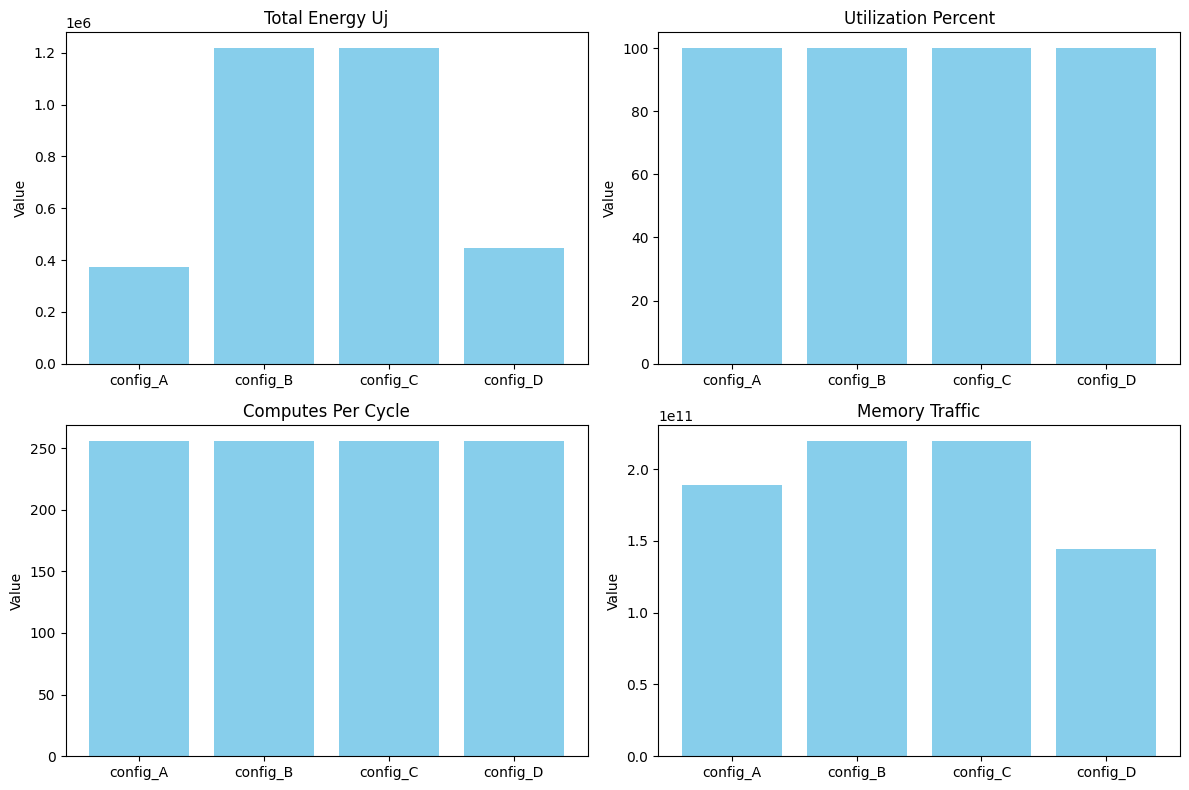

{'total_energy_uJ': [371837.08999999997,
  1218081.94,
  1218081.94,
  446798.72000000003],
 'utilization_percent': [100.0, 100.0, 100.0, 100.0],
 'computes_per_cycle': [255.99999784041145,
  255.99999784041145,
  255.99999784041145,
  255.99999784041145],
 'memory_traffic': [188630668672, 219846893633, 219846893633, 144125814898]}

In [12]:
plot_mapping_search(opt_config, curr_opt)

[INFO] 2025-05-03 00:04:53,565 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


Buffer and Arithmetic Levels
----------------------------
Level 0
-------
=== MAC ===

    SPECS
    -----
    Word bits             : 8
    Instances             : 256 (32*8)
    Compute energy        : 15.57 pJ

    STATS
    -----
    Utilized instances (max)     : 1
    Utilized instances (average) : 1
    Cycles                       : 8589934592
    Algorithmic Computes (total) : 8589934592
    Actual Computes (total)      : 8589934592
    Gated Computes (total)       : 0
    Skipped Computes (total)     : 0
    Energy (total)               : 133784795296.56 pJ
    Area (total)                 : 768450.56 um^2


Level 1
-------
=== reg ===

    SPECS
    -----
        Technology                      : SRAM
        Data storage size               : 1
        Data word bits                  : 8
        Data block size                 : 1
        Metadata storage width(bits)    : 4
        Metadata storage depth          : 1
        Cluster size                    : 1
        Instan